In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "gauss_gauss_10d_default"
model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users

--- Step 1: Load model and create simulator ---
Model loaded: GaussGaussMultiDimModel(dim=10, n_obs=25, marginal_of_interest=0)
Model loaded: GaussGaussMultiDimModel(dim=10, n_obs=25, marginal_of_interest=0)


INFO:abcnre.simulation.simulator:Created temporary observed data for prior sampling mode


In [2]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(123)
key, subkey_learn = jax.random.split(key)


# regressor_config = get_nn_config(network_name="deepset",
#                           network_size = "default",
#                           training_size = "default",
#                           task_type = "regressor",
#                           lr_scheduler_name = "reduce_on_plateau",
#                           lr_scheduler_variant = "default",
#                           stopping_rules_variant = "balanced",
#                           experiment_name = None, 
#                           training_set_size= 10000, 
#                           validation_set_size= 1000)
# simulator.train_summary_network(subkey_learn, regressor_config)

# key, subkey_check = jax.random.split(key)
# empirical_correlation = simulator.check_summary_stats_correlation(
#     subkey_check)
# sigma0 = model.sigma0
# sigma = model.sigma
# n_obs = model.n_obs
# import jax.numpy as jnp

# theoretical_correlation = sigma0/jnp.sqrt(sigma**2/n_obs + sigma0**2)

# print("Empirical correlation (s(x), mu_j):", empirical_correlation,"\nTheoretical correlation (mean(x_j) and mu_j)", theoretical_correlation)

--- Step 1.5 : Learn Summary Stats (Optional) ---


In [3]:
# n_samples = 1000 
# key, subkey = jax.random.split(key)
# phi_samples, x_samples = simulator.model.sample_phi_x_multiple(
#     subkey, n_samples=n_samples
# )
# # Compute summary statistics for the generated samples
# summary_stats = simulator.summary_stat_fn(x_samples)

# print(f'Shapes: phi_samples: {phi_samples.shape}, x_samples: {x_samples.shape}, summary_stats: {summary_stats.shape}')
# import seaborn as sns
# import matplotlib.pyplot as plt
# import jax.numpy as jnp

# plt.scatter(phi_samples, summary_stats[:, 0])
# plt.xlabel("phi_samples")
# plt.ylabel("summary_stats[:, 0]")
# plt.title("Scatter plot of phi_samples vs summary_stats[:, 0]")
# plt.show()
# jnp.corrcoef(phi_samples[:,0], summary_stats[:, 0])


In [4]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")
import jax
import jax.numpy as jnp
key = jax.random.PRNGKey(1234)
# Ensure the model is initialized
model = simulator.model

key, key_prior = jax.random.split(key)
true_theta = model.get_prior_sample(key_prior)
print(true_theta.shape)

true_phi = 20.
true_theta = true_theta.at[model.marginal_of_interest].set(true_phi)

key, subkey_sample = jax.random.split(key)
x_obs = model.simulate_data(subkey_sample, true_theta)
simulator.update_observed_data(x_obs)


quantile_distance = .1
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
(10,)


INFO:abcnre.simulation.simulator:Computed epsilon = 7.289465 for 10.0% quantile


In [5]:
import numpy as np
model.predefined_summary_stat_fn(x_obs), simulator.summary_stat_fn(x_obs)

(Array([19.853662], dtype=float32), Array([19.853662], dtype=float32))

In [6]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml

save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator_observed_data.npy
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator.yaml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulat

--- Step 2.2: Save model to YAML (Optional) ---


In [7]:

print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

from abcnre.utils.comparison import are_simulators_equivalent

simulators_match = are_simulators_equivalent(simulator, simulator_loaded)
print(f"Simulators match: {'YES' if simulators_match else 'NO'}")

INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator_observed_data.npy
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/simulator/simulator_observed_data.npy
INFO:abcnre.simulation.simulator:Using provided epsilon = 7.289465
INFO:abcnre.simulation.simulator:Using provided epsilon = 7.289465


--- Step 2.3 : Load model from YAML and check (Optional) ---
Simulators match: YES


In [8]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="conditioned_deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None, 
                          training_set_size= 100000,
                          validation_set_size= 10000)    

--- Step 3.1: Create NNConfig for training ---


INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Enabled pre-simulated data with training_set_size: 100000
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Enabled pre-simulated data with training_set_size: 100000
INFO:abcnre.training.config:Set validation_set_size: 10000
INFO:abcnre.training.config:Created NN config: classifier_conditioned_deepset_default_default (task: classifier)
INFO:abcnre.training.config:Set validation_set_size: 10000
INFO:abcnre.training.config:Created NN config: classifier_conditioned_deepset_default_default (task: classifier)


In [9]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [10]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")


key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)  # Store few phi samples


INFO:abcnre.inference.estimator:Using ConditionedDeepSet without summary statistics


--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: ConditionedDeepSet
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: ConditionedDeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.0005
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 256
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.0005
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 256
INFO:abcnre.training.component

Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.15587732195854187
   - Total simulations: 493483


In [11]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-

--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---


In [12]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)
from abcnre.utils.comparison import are_estimators_equivalent

estimators_match = are_estimators_equivalent(estimator, estimator_loaded)
print(f"Estimators match: {'YES' if estimators_match else 'NO'}")

INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.simulation.simulator:Using provided epsilon = 7.289465
INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_10D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.simulation.simulator:Using provided epsilon = 7.289465
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for ConditionedDeepSet network
INFO:abcnre.training.r

--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
Estimators match: YES


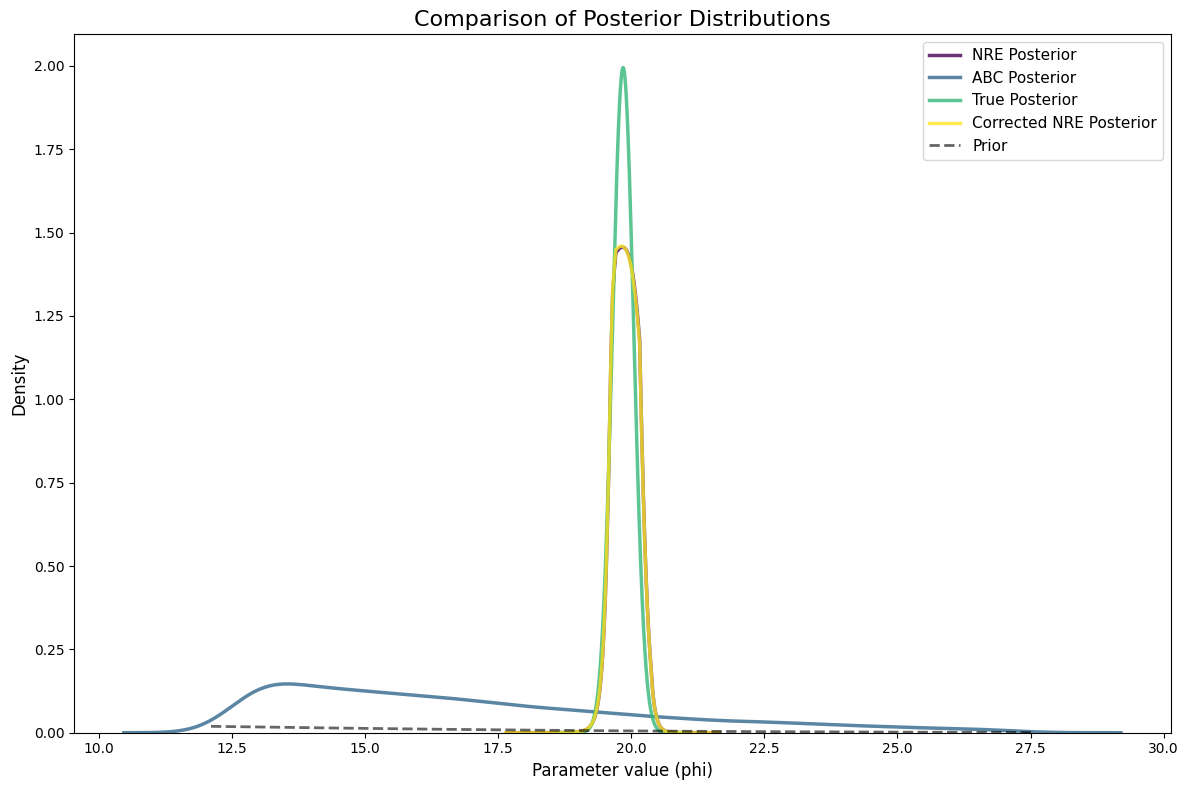

In [16]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison
import numpy as np

abc_phi_samples = estimator.stored_phis
min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)

n_grid = 10000  # Number of grid points for the posterior distribution
abc_phi_grid = np.linspace(min_phi, max_phi, n_grid)

# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(estimator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, 
                                       initial_bounds=(min_phi, max_phi), 
                                        n_grid_points=n_grid)

# Get prior for plotting
prior_pdf_values = simulator.model.prior_phi_pdf(abc_phi_grid)

true_grid, true_pdf = get_normalized_pdf(simulator.model.get_posterior_phi_distribution(simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unnormalized_corrected_nre_pdf(estimator)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
                                    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
                                    initial_bounds=(min_phi, max_phi),
                                    n_grid_points=n_grid
)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=n_grid
)

# Generate the comparison plot - flatten ABC samples to 1D
plot_posterior_comparison(
    distributions={
        'NRE Posterior': (phi_grid, nre_pdf), 
        'ABC Posterior': abc_phi_samples.flatten(),  # Flatten to 1D array
        'True Posterior': (true_grid, true_pdf), 
        'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)
    },
    prior_pdf=(abc_phi_grid, prior_pdf_values),
    # xlim=(18,22),
    # save_path=output_dir / "posterior_comparison.png"
)




In [14]:
# from abcnre.diagnostics.calibration import run_abc_sbc
# from abcnre.diagnostics.viz import plot_sbc_ranks

# # --- Step 7: Simulation-Based Calibration (SBC) ---
# print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
# import jax
# key  = jax.random.PRNGKey(42)
# num_posterior_samples = 128  
# sbc_results = run_abc_sbc(
#     key=key,
#     estimator=estimator,
#     num_sbc_rounds=10,
#     num_posterior_samples=num_posterior_samples
# )


# plot_sbc_ranks(sbc_results)

In [15]:
# print("\n--- Step 8: Creating Samplers and Running Metrics ---")
# from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf, get_sampler_from_pdf
# from abcnre.diagnostics.metrics import generate_and_evaluate_metrics, save_metrics_to_csv


# # Define bounds for posterior calculation based on reference samples
# min_phi = np.min(abc_phi_samples) - 1.0
# max_phi = np.max(abc_phi_samples) + 1.0

# # --- Create all necessary sampler functions ---
# # A sampler is a function that takes (n_samples, key) and returns samples

# unorm_nre_pdf = get_unnormalized_nre_pdf(estimator)
# nre_sampler = get_sampler_from_pdf(
#     unnormalized_pdf_func=unorm_nre_pdf,
#     initial_bounds=(min_phi, max_phi)
# )

# unorm_corrected_nre_pdf = get_unnormalized_corrected_nre_pdf(
#     estimator, phi_samples=abc_phi_samples
# )
# corrected_nre_sampler = get_sampler_from_pdf(
#     unnormalized_pdf_func=unorm_corrected_nre_pdf,
#     initial_bounds=(min_phi, max_phi)
# )

# true_sampler = simulator.get_true_posterior_samples

# # abc_sampler = lambda: key, n_s:  simulator.get_abc_posterior_samples()

# # --- Run the metrics suite ---
# approx_samplers_dict = {
#     "NRE_Standard": nre_sampler,
#     "NRE_Corrected": corrected_nre_sampler,
#     # "ABC": 
# }

# # The key here will be split inside the function for each sampler
# key = jax.random.PRNGKey(123)
# all_metrics_results = generate_and_evaluate_metrics(
#     key=key,
#     true_sampler=true_sampler,
#     approx_samplers_dict=approx_samplers_dict,
#     n_samples=5000
# )

# print("\n--- Quantitative Results ---")
# save_metrics_to_csv(all_metrics_results, results_dir / "diagnostics_metrics.csv")